In [1]:
# Importation des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import joblib
import shap
import glob

C:\Users\Robin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Chargement des données
folder_path = "data/septembre2024"  # Adapter au chemin correct
csv_files = glob.glob(f"{folder_path}/*.csv")
dataframes = [pd.read_csv(file) for file in csv_files]
data = pd.concat(dataframes, ignore_index=True)


In [3]:

# Affichage des informations de base
print("Aperçu des données initiales:")
print(data.head())
print(data.info())

Aperçu des données initiales:
                           listing_url  bathrooms  bedrooms  accommodates  \
0    https://www.airbnb.com/rooms/3109        1.0       1.0             2   
1    https://www.airbnb.com/rooms/5396        1.0       0.0             2   
2    https://www.airbnb.com/rooms/7397        1.0       2.0             4   
3  https://www.airbnb.com/rooms/241715        1.0       3.0             6   
4    https://www.airbnb.com/rooms/9359        1.0       1.0             1   

  bathrooms_text  beds       property_type        room_type  amenities  \
0         1 bath   1.0  Entire rental unit  Entire home/apt         15   
1         1 bath   1.0  Entire rental unit  Entire home/apt         38   
2         1 bath   1.0  Entire rental unit  Entire home/apt         25   
3         1 bath   0.0  Entire rental unit  Entire home/apt          6   
4         1 bath   1.0  Entire rental unit  Entire home/apt          7   

    latitude  longitude neighbourhood_cleansed  minimum_nights

In [4]:
# Préparation des données
selected_columns = [
    'neighbourhood_cleansed', 'latitude', 'longitude', 
    'property_type', 'room_type', 'accommodates',
    'bathrooms', 'bedrooms', 'beds', 'price',
    'minimum_nights', 'maximum_nights', 'instant_bookable', 'availability_365'
]
data = data[selected_columns]

In [5]:
data

,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,instant_bookable,availability_365
0,Observatoire,48.831910,2.318700,Entire rental unit,Entire home/apt,2,1.0,1.0,1.0,113.0,2,30,t,297
1,Hôtel-de-Ville,48.852470,2.358350,Entire rental unit,Entire home/apt,2,1.0,0.0,1.0,95.0,2,730,f,77
2,Hôtel-de-Ville,48.859090,2.353150,Entire rental unit,Entire home/apt,4,1.0,2.0,1.0,145.0,10,130,f,316
3,Buttes-Chaumont,48.893464,2.378341,Entire rental unit,Entire home/apt,6,1.0,3.0,0.0,450.0,5,120,f,173
4,Louvre,48.860060,2.348630,Entire rental unit,Entire home/apt,1,1.0,1.0,1.0,75.0,180,360,f,358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63956,Opéra,48.876980,2.343230,Private room in rental unit,Private room,4,1.0,1.0,1.0,114.0,1,365,f,0
63957,Entrepôt,48.874400,2.371717,Entire rental unit,Entire home/apt,4,1.0,1.0,1.0,100.0,3,60,f,362
63958,Passy,48.838180,2.257970,Entire rental unit,Entire home/apt,4,1.0,1.0,2.0,77.0,1,365,t,18
63959,Batignolles-Monceau,48.875698,2.289969,Entire rental unit,Entire home/apt,6,2.5,3.0,3.0,640.0,2,365,t,356


In [6]:
# Traitement des valeurs aberrantes
price_q1, price_q3 = np.percentile(data['price'], [25, 75])
iqr = price_q3 - price_q1
lower_bound = price_q1 - 1.5 * iqr
upper_bound = price_q3 + 1.5 * iqr
data = data[(data['price'] >= lower_bound) & (data['price'] <= upper_bound)]


In [7]:
# Assurez-vous que 'data' est une copie indépendante avant de le modifier
data = data.copy()

# Création de nouvelles variables
data['bedrooms_per_bed'] = data['bedrooms'] / data['beds'].replace(0, np.nan)
data['accommodates_per_bathroom'] = data['accommodates'] / data['bathrooms'].replace(0, np.nan)
data['accommodates_bedrooms'] = data['accommodates'] * data['bedrooms']
data['price_per_accommodate'] = data['price'] / data['accommodates']


In [8]:
# Gestion des outliers pour 'minimum_nights' et 'maximum_nights'
for col in ['minimum_nights', 'maximum_nights']:
    if col in data.columns:
        q1, q3 = data[col].quantile(0.25), data[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

In [9]:
data.loc[:, 'price'] = np.log1p(data['price'])


In [10]:
data

,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,instant_bookable,availability_365,bedrooms_per_bed,accommodates_per_bathroom,accommodates_bedrooms,price_per_accommodate
0,Observatoire,48.831910,2.318700,Entire rental unit,Entire home/apt,2,1.0,1.0,1.0,4.736198,2,30,t,297,1.0,2.0,2.0,56.50
1,Hôtel-de-Ville,48.852470,2.358350,Entire rental unit,Entire home/apt,2,1.0,0.0,1.0,4.564348,2,730,f,77,0.0,2.0,0.0,47.50
3,Buttes-Chaumont,48.893464,2.378341,Entire rental unit,Entire home/apt,6,1.0,3.0,0.0,6.111467,5,120,f,173,NaN,6.0,18.0,75.00
5,Popincourt,48.863730,2.370930,Entire rental unit,Entire home/apt,2,1.0,1.0,1.0,5.509388,4,31,f,183,1.0,2.0,2.0,123.00
9,Popincourt,48.861590,2.379520,Entire rental unit,Entire home/apt,4,1.0,2.0,2.0,5.342334,1,45,t,84,1.0,4.0,8.0,52.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63955,Hôtel-de-Ville,48.850912,2.354879,Entire rental unit,Entire home/apt,2,1.0,0.0,1.0,4.948760,1,365,t,286,0.0,2.0,0.0,70.00
63956,Opéra,48.876980,2.343230,Private room in rental unit,Private room,4,1.0,1.0,1.0,4.744932,1,365,f,0,1.0,4.0,4.0,28.50
63957,Entrepôt,48.874400,2.371717,Entire rental unit,Entire home/apt,4,1.0,1.0,1.0,4.615121,3,60,f,362,1.0,4.0,4.0,25.00
63958,Passy,48.838180,2.257970,Entire rental unit,Entire home/apt,4,1.0,1.0,2.0,4.356709,1,365,t,18,0.5,4.0,4.0,19.25


In [11]:
categorical_columns = ['neighbourhood_cleansed', 'property_type', 'room_type', 'instant_bookable']
num_features = [
    'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 
    'beds', 'minimum_nights', 'maximum_nights', 'availability_365',
    'bedrooms_per_bed', 'accommodates_per_bathroom', 'accommodates_bedrooms', 'price_per_accommodate'
]

In [12]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ]
)

In [13]:
# Séparation des données
X = data.drop('price', axis=1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

In [15]:
# Modèles à évaluer
models = {
    'RandomForest': RandomForestRegressor(random_state=42, n_jobs=-1),
    'XGBoost': XGBRegressor(random_state=42, n_jobs=-1),
    'LightGBM': LGBMRegressor(random_state=42, n_jobs=-1),
    'CatBoost': CatBoostRegressor(verbose=0, random_state=42, thread_count=-1),
    'Ridge': Ridge(random_state=42)
}


In [16]:
print(X_train.isnull().sum())


neighbourhood_cleansed       0
latitude                     0
longitude                    0
property_type                0
room_type                    0
accommodates                 0
bathrooms                    0
bedrooms                     0
beds                         0
minimum_nights               0
maximum_nights               0
instant_bookable             0
availability_365             0
bedrooms_per_bed             0
accommodates_per_bathroom    0
accommodates_bedrooms        0
price_per_accommodate        0
dtype: int64


In [17]:
# Entraînement et évaluation des modèles
model_scores = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    mean_cv_score = -np.mean(cv_scores)
    model_scores[name] = mean_cv_score
    print(f"{name}: Cross-Validated MAE = {mean_cv_score:.4f}")


RandomForest: Cross-Validated MAE = 0.0010
XGBoost: Cross-Validated MAE = 0.0057
LightGBM: Cross-Validated MAE = 0.0064
CatBoost: Cross-Validated MAE = 0.0056
Ridge: Cross-Validated MAE = 0.1273


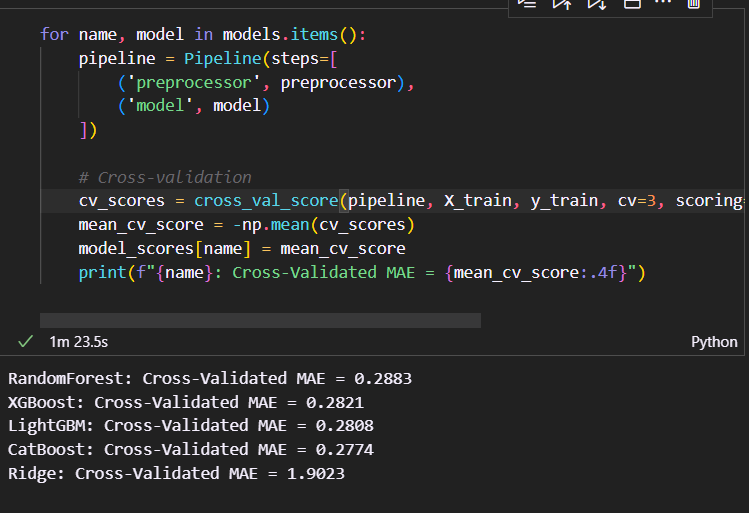

In [18]:
# Modèle avec le meilleur MAE
best_model_name = min(model_scores, key=model_scores.get)
best_model_class = models[best_model_name]
print(f"Meilleur modèle: {best_model_name} avec MAE = {model_scores[best_model_name]:.4f}")


Meilleur modèle: RandomForest avec MAE = 0.0010


In [19]:
# Ajustement final du meilleur modèle
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', best_model_class)
])
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', RobustScaler(),
                                                  ['latitude', 'longitude',
                                                   'accommodates', 'bathrooms',
                                                   'bedrooms', 'beds',
                                                   'minimum_nights',
                                                   'maximum_nights',
                                                   'availability_365',
                                                   'bedrooms_per_bed',
                                                   'accommodates_per_bathroom',
                                                   'accommodates_bedrooms',
                                                   'price_per_accommodate']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['neighbourhood_cleansed',
                                                   'property_type', 'room_type',
                                                   'instant_bookable'])])),
                ('model', RandomForestRegressor(n_jobs=-1, random_state=42))])

In [20]:
print(X_test.isnull().sum())  # Vérifiez si X_test contient des NaN
print(X_test.describe())  # Vérifiez les valeurs aberrantes


neighbourhood_cleansed         0
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                      0
bedrooms                       0
beds                           0
minimum_nights                 0
maximum_nights                 0
instant_bookable               0
availability_365               0
bedrooms_per_bed             429
accommodates_per_bathroom     34
accommodates_bedrooms          0
price_per_accommodate          0
dtype: int64
          latitude    longitude  accommodates    bathrooms     bedrooms  \
count  8118.000000  8118.000000   8118.000000  8118.000000  8118.000000   
mean     48.864111     2.344792      3.157182     1.126571     1.207317   
std       0.018615     0.034362      1.466619     0.377496     0.795305   
min      48.816270     2.228970      1.000000     0.000000     0.000000   
25%      48.850021     2.323130      2.000000     1

In [21]:
X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]
print(X_test.isnull().sum())  # Vérifiez si X_test contient des NaN
print(X_test.describe())  # Vérifiez les valeurs aberrantes


neighbourhood_cleansed       0
latitude                     0
longitude                    0
property_type                0
room_type                    0
accommodates                 0
bathrooms                    0
bedrooms                     0
beds                         0
minimum_nights               0
maximum_nights               0
instant_bookable             0
availability_365             0
bedrooms_per_bed             0
accommodates_per_bathroom    0
accommodates_bedrooms        0
price_per_accommodate        0
dtype: int64
          latitude    longitude  accommodates    bathrooms     bedrooms  \
count  7658.000000  7658.000000   7658.000000  7658.000000  7658.000000   
mean     48.864070     2.344827      3.170018     1.132215     1.216114   
std       0.018601     0.034242      1.471981     0.364065     0.798108   
min      48.816270     2.228970      1.000000     0.500000     0.000000   
25%      48.850043     2.323165      2.000000     1.000000     1.000000   
50%      4

In [22]:
# Prédictions et évaluation
y_pred = np.expm1(pipeline.predict(X_test))
y_test_actual = np.expm1(y_test)
mae = mean_absolute_error(y_test_actual, y_pred)
print(f"MAE sur le jeu de test avec {best_model_name}: {mae:.4f}")


MAE sur le jeu de test avec RandomForest: 0.1040


In [23]:
# Ajout d'un modèle Deep Learning
# Conversion en tableau dense (NumPy array)
X_train_scaled = preprocessor.fit_transform(X_train).toarray()
X_test_scaled = preprocessor.transform(X_test).toarray()


In [24]:
dl_model = Sequential([
    Dense(128, activation='relu', input_dim=X_train_scaled.shape[1]),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Sortie pour la régression
])
dl_model.compile(optimizer='adam', loss='mean_absolute_error')
dl_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)




Epoch 1/50

766/766 [==============================] - 2s 2ms/step - loss: 0.6086 - val_loss: 0.1598
Epoch 2/50
766/766 [==============================] - 1s 1ms/step - loss: 0.3940 - val_loss: 0.0959
Epoch 3/50
766/766 [==============================] - 1s 2ms/step - loss: 0.3539 - val_loss: 0.1028
Epoch 4/50
766/766 [==============================] - 1s 2ms/step - loss: 0.3255 - val_loss: 0.1291
Epoch 5/50
766/766 [==============================] - 1s 1ms/step - loss: 0.2970 - val_loss: 0.1894
Epoch 6/50
766/766 [==============================] - 1s 1ms/step - loss: 0.2755 - val_loss: 0.0565
Epoch 7/50
766/766 [==============================] - 1s 2ms/step - loss: 0.2536 - val_loss: 0.0697
Epoch 8/50
766/766 [==============================] - 1s 2ms/step - loss: 0.2387 - val_loss: 0.0518
Epoch 9/50
766/766 [==============================] - 1s 2ms/step - loss: 0.2241 - val_loss: 0.0517
Epoch 10/50
766/766 [==============================] - 1s 2ms/step - loss: 0.2096 - val_loss: 0.0

In [25]:
# Prédictions avec le modèle DL
y_pred_dl = dl_model.predict(X_test_scaled).flatten()
y_pred_dl_actual = np.expm1(y_pred_dl)
mae_dl = mean_absolute_error(y_test_actual, y_pred_dl_actual)
print(f"MAE avec Deep Learning: {mae_dl:.4f}")

240/240 [==============================] - 0s 914us/step
MAE avec Deep Learning: 5.7743


Taille de 'errors': (7658,)
Quelques valeurs de 'errors': 19765   -1.975309e-12
34913   -6.821210e-13
63470   -7.954719e-02
18920   -4.987086e-02
62026    1.534772e-12
28539    4.604317e-12
53782    9.663381e-13
59117    3.126388e-13
7505     1.477929e-12
16953    9.379164e-13
Name: price, dtype: float64


MemoryError: Unable to allocate 2.73 PiB for an array with shape (384142249470537,) and data type float64

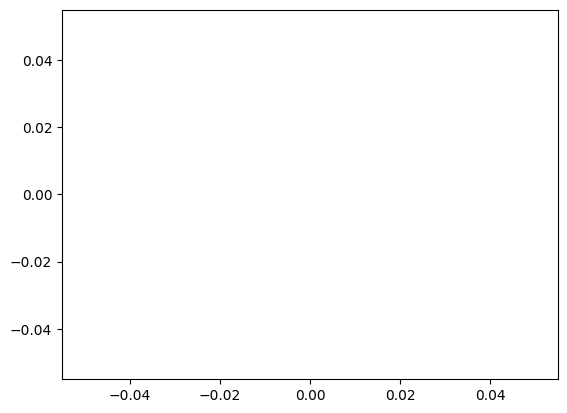

In [27]:
# Visualisation des erreurs
errors = y_test_actual - y_pred
print(f"Taille de 'errors': {errors.shape}")
print(f"Quelques valeurs de 'errors': {errors[:10]}")
errors_np = errors.to_numpy()
sns.histplot(errors_np, kde=True)
plt.title('Distribution des erreurs')
plt.show()


In [28]:
# Stacking de modèles
base_models = [
    ('rf', RandomForestRegressor(random_state=42)),
    ('xgb', XGBRegressor(random_state=42)),
    ('lgbm', LGBMRegressor(random_state=42))
]

In [29]:
stack_model = StackingRegressor(estimators=base_models, final_estimator=Ridge(random_state=42))
stack_model.fit(X_train_scaled, y_train)
y_pred_stack = stack_model.predict(X_test_scaled)
mae_stack = mean_absolute_error(y_test_actual, np.expm1(y_pred_stack))
print(f"MAE avec Stacking: {mae_stack:.4f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1372
[LightGBM] [Info] Number of data points in the train set: 30622, number of used features: 55
[LightGBM] [Info] Start training from score 5.043759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1351
[LightGBM] [Info] Number of data points in the train set: 24497, number of used features: 53
[LightGBM] [Info] Start training from score 5.044549
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

In [32]:
import pandas as pd

# Calcul des pourcentages de réussite
error_margin = 0.05  # 5% de marge d'erreur
within_margin = np.abs((y_pred - y_test_actual) / y_test_actual) <= error_margin
success_rate = within_margin.mean() * 100

print(f"Pourcentage de prédictions correctes (marge de ±5%): {success_rate:.2f}%")

# Exporter les prix réels et estimés dans un fichier CSV
results_df = pd.DataFrame({
    'Prix Réel': y_test_actual,
    'Prix Estimé': y_pred,
    'Erreur': y_test_actual - y_pred,
    'Précision (%)': 100 - (np.abs((y_test_actual - y_pred) / y_test_actual) * 100)
})

# Exporter vers un fichier CSV
results_df.to_csv('predictions_results.csv', index=False, float_format='%.2f')
print("Les résultats ont été exportés dans le fichier 'predictions_results.csv'.")


Pourcentage de prédictions correctes (marge de ±5%): 99.79%
Les résultats ont été exportés dans le fichier 'predictions_results.csv'.


In [33]:
# Échantillon des valeurs réelles et prédites
results_sample = pd.DataFrame({
    'Prix Réel': y_test_actual[:10],
    'Prix Estimé': y_pred[:10],
    'Erreur Absolue': np.abs(y_test_actual[:10] - y_pred[:10])
})
print(results_sample)


       Prix Réel  Prix Estimé  Erreur Absolue
19765      110.0   110.000000    1.975309e-12
34913      153.0   153.000000    6.821210e-13
63470      301.0   301.079547    7.954719e-02
18920      337.0   337.049871    4.987086e-02
62026      100.0   100.000000    1.534772e-12
28539      320.0   320.000000    4.604317e-12
53782      134.0   134.000000    9.663381e-13
59117       86.0    86.000000    3.126388e-13
7505       150.0   150.000000    1.477929e-12
16953      150.0   150.000000    9.379164e-13


In [36]:
import joblib

# Exporter le pipeline complet avec joblib
joblib_file = "best_model_pipeline.pkl"
joblib.dump(pipeline, joblib_file)

print(f"Modèle exporté avec succès dans le fichier '{joblib_file}'.")


Modèle exporté avec succès dans le fichier 'best_model_pipeline.pkl'.
